### Import Libraries

In [1]:
import numpy as np
import os
import torch
import cv2
from PIL import Image
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

from importlib import reload
import model_architectures
import utilities

reload(model_architectures)
from model_architectures import VAESegment, Data3DSegToSeg

reload(utilities)
from utilities import get_colormaps

C:\compute\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Paths

In [2]:
research_dir = r"D:/school/research"
code_dir = os.path.join(research_dir, "code")
model_dir = os.path.join(code_dir, "paper_two_code", "models")
data_dir = os.path.join(research_dir, "data")
dhcp_rel2 = os.path.join(data_dir, "dhcp_rel2")
processed_dir = os.path.join(dhcp_rel2, "processed")
volume_dir = os.path.join(processed_dir, "volumes")
seg_dir = os.path.join(processed_dir, "segments")
seg_vol_dir = os.path.join(processed_dir, "volume_segments")
pred_dir = os.path.join(dhcp_rel2, "predictions")
seg_pred_dir = os.path.join(pred_dir, "vae_9seg")

l1_dir = os.path.join(volume_dir, "l1")
l5_dir = os.path.join(volume_dir, "l5")

l1_seg_dir = os.path.join(seg_dir, "l1")
l5_seg_dir = os.path.join(seg_dir, "l5")

l1_seg_vol_dir = os.path.join(seg_vol_dir, "l1")
l5_seg_vol_dir = os.path.join(seg_vol_dir, "l5")

l1_seg_pred_dir = os.path.join(seg_pred_dir, "l1")
l5_seg_pred_dir = os.path.join(seg_pred_dir, "l5")

fig_dir = "paper_two_figures"

### Define Data

In [3]:
np.random.seed(42)
num_samples = int(len(os.listdir(l1_dir)) / 2)
samples = np.array([i for i in range(0, num_samples)])
np.random.shuffle(samples)

split_val = int(0.8 * num_samples)
train_indices = samples[0:split_val]
val_indices = samples[split_val:]

num_test = int(len(os.listdir(l5_dir)) / 2)
test_indices = np.array([i for i in range(0, num_test)])


# Define Datasets
train = Data3DSegToSeg(l1_dir, l1_seg_vol_dir, train_indices)
val = Data3DSegToSeg(l1_dir, l1_seg_vol_dir, val_indices)
test = Data3DSegToSeg(l5_dir, l5_seg_vol_dir, test_indices)

### Helper Functions

In [20]:
model_options = {
    "9 Segments to 9 Segments": {
        "weights_t1": "vae_rel2t1_seg9_to_seg9.pt",
        "weights_t2": "vae_rel2t2_seg9_to_seg9.pt",
        "model": VAESegment(9, 9),
        "shape": (1, 9, 256, 256, 256)
    },
    "1 Segment to 1 Segment": {
        "weights_t1": "vae_rel2t1_seg_to_seg{}.pt",
        "weights_t2": "vae_rel2t2_seg_to_seg{}.pt",
        "model": VAESegment(1, 1),
        "shape": (1, 1, 256, 256, 256)
    }
}

max_z = 10
reds, blues = get_colormaps(max_z)
colorbar = Image.open("colorbar.png")
segments = [
    "Cerebrospinal Fluid",
    "Cortical Grey Matter",
    "White Matter",
    "Background",
    "Ventricle",
    "Cerebelum",
    "Deep Grey Matter",
    "Brainstem",
    "Hippocampus"
]

# Helper functions
def get_dataset(batch):
    if batch=="Train":
        return train
    elif batch=="Validation":
        return val
    else:
        return test

# @st.cache(allow_output_mutation=True)
def load_image(batch, subject):
    """Get subject images from correct batch."""
    data = get_dataset(batch)[int(subject)-1]
    
    # T1
    og_t1 = np.stack((data[0],)*3, axis=-1)
    og_t1 = np.rot90(og_t1, axes=(1,2))
    og_t1 = np.concatenate((og_t1, np.ones((9, 256, 256, 256, 1))), axis=4)

    norm_t1 = get_prediction(data[0], model_t1)
    norm_t1 = np.rot90(norm_t1, axes=(1,2))
    
    # T2
    og_t2 = np.stack((data[1],)*3, axis=-1)
    og_t2 = np.rot90(og_t2, axes=(1,2))
    og_t2 = np.concatenate((og_t2, np.ones((9, 256, 256, 256, 1))), axis=4)

    norm_t2 = get_prediction(data[1], model_t2)
    norm_t2 = np.rot90(norm_t2, axes=(1,2))

    return og_t1, norm_t1, og_t2, norm_t2

def load_model(config, version):
    model_path = os.path.join(model_dir, config[f"weights_{version}"])
    model = config["model"]
    model.load_state_dict(torch.load(model_path))
    model.cuda()
    model.eval()
    
    return model
        
def load_models_data(config, batch, subject, modality):
    mode = 1 if modality == "t2" else 0
    data = get_dataset(batch)[int(subject)-1][mode]
    norm = np.empty_like(data)
    for idx in range(0, len(segments)):
        img = data[idx]
        model_path = os.path.join(model_dir, config[f"weights_{modality}"].format(idx))
        model = config["model"]
        model.load_state_dict(torch.load(model_path))
        model.cuda()
        model.eval()
        
        pred = model(torch.Tensor(np.reshape(img, config["shape"])).cuda())
        norm_slc = img - np.reshape(pred.cpu().detach().numpy(), img.shape)
        
        if stdev_version == "Global":
            norm[idx] = norm_slc / 0.1
        else:
            norm[idx] = (norm_slc - np.mean(norm_slc)) / np.std(norm_slc)

    og = np.stack((data,)*3, axis=-1)
    og = np.rot90(og, axes=(1,2))
    og = np.concatenate((og, np.ones((9, 256, 256, 256, 1))), axis=4)

    # norm /= 0.1
    norm = np.rot90(norm, axes=(1,2))
    
    
    return og, norm

def get_prediction(img, model):
    pred = model(torch.Tensor(np.reshape(img, config["shape"])).cuda())
    diff = img - np.reshape(pred.cpu().detach().numpy(), img.shape)
    
    if stdev_version == "Global":
        diff /= 0.1
    else:
        means = [np.mean(x) for x in diff]
        stdevs = [np.std(x) for x in diff]
        for i in range(0, 9):
            diff[i] = (diff[i] - means[i]) / stdevs[i]
            
    return diff

def get_cluster_mask(array, min_cluster):
    cluster_map = array.copy()
    cluster_map[cluster_map != 0] = 1
    cluster_map = cluster_map.astype('uint8')
    
    _, labels = cv2.connectedComponents(cluster_map)
    values, counts = np.unique(labels, return_counts=True)
    labels[np.isin(labels, [x for x, y in zip(values, counts) if y < min_cluster])] = 0
    labels[labels != 0] = 1
    
    return labels

def get_overlay(diff):
    rounded = np.round(diff, 1)
    # Values that fall below the mean/threshold
    below_zero = rounded.copy()
    below_zero[below_zero > -threshold] = 0
    below_zero = np.clip(below_zero, -max_z, 0)
    
    # Values that fall above the mean/threshold
    above_zero = rounded.copy()
    above_zero[above_zero < threshold] = 0
    above_zero = np.clip(above_zero, 0, max_z)
    
    if filter_clusters:
        az_mask = get_cluster_mask(above_zero, cluster_size)
        above_zero *= az_mask
        
        bz_mask = get_cluster_mask(below_zero, cluster_size)
        below_zero *= bz_mask
    
    combined = np.zeros((*above_zero.shape, 4))
    for value, color in reds.items():
        combined[above_zero == value] = color
    for value, color in blues.items():
        combined[below_zero == value] = color
        
    return combined

def get_slice_segment(img_in, norm, segment, slice_number):
    img = img_in[segment]
    image_pil = Image.fromarray(np.uint8(img[:,:,slice_number-1] * 255), mode="RGBA")

    overlay = get_overlay(norm[segment][:,:,slice_number-1])
    overlay_pil = Image.fromarray(np.uint8(overlay * 255), mode="RGBA")

    return Image.alpha_composite(image_pil, overlay_pil)

def get_slice(img_in, norm, slice_number):
    img = img_in.copy()
    image_pil = Image.fromarray(np.uint8(img[:,:,slice_number-1] * 255), mode="RGBA")
    
    overlay = get_overlay(norm[:,:,slice_number-1])
    overlay_pil = Image.fromarray(np.uint8(overlay * 255), mode="RGBA")

    return Image.alpha_composite(image_pil, overlay_pil)

def get_banded_layer(az, az_mask, bz, bz_mask):
    az[np.invert(az_mask)] = 0
    bz[np.invert(bz_mask)] = 0
    comb = np.zeros((*az.shape, 4))
    for value, color in reds.items():
        comb[az == value] = color
    for value, color in blues.items():
        comb[bz == value] = color
        
    return comb

def get_banded_overlay_slice(img, norm, slice_number):
    image_pil = Image.fromarray(np.uint8(img[:,:,slice_number-1] * 255), mode="RGBA")

    rounded = np.round(norm[:,:,slice_number-1], 1)
    # Values that fall below the mean/threshold
    below_zero = rounded.copy()
    below_zero[below_zero > -threshold] = 0
    below_zero = np.clip(below_zero, -max_z, 0)

    # Values that fall above the mean/threshold
    above_zero = rounded.copy()
    above_zero[above_zero < threshold] = 0
    above_zero = np.clip(above_zero, 0, max_z)

    # 4 to inf
    high_band = get_banded_layer(
        above_zero.copy(),
        ((above_zero >= 4) & (above_zero < np.inf)),
        below_zero.copy(),
        ((below_zero > -np.inf) & (below_zero <= -4))
    )
    medium_band = get_banded_layer(
        above_zero.copy(),
        ((above_zero >= 3) & (above_zero < 4)),
        below_zero.copy(),
        ((below_zero > -4) & (below_zero <= -3))
    )
    low_band = get_banded_layer(
        above_zero.copy(),
        ((above_zero >= 2) & (above_zero < 3)),
        below_zero.copy(),
        ((below_zero > -3) & (below_zero <= -2))
    )

    # overlay = get_overlay(norm[:,:,slice_number-1])
    high_pil = Image.fromarray(np.uint8(high_band * 255), mode="RGBA")
    medium_pil = Image.fromarray(np.uint8(medium_band * 255), mode="RGBA")
    low_pil = Image.fromarray(np.uint8(low_band * 255), mode="RGBA")

    high_overlay = Image.alpha_composite(image_pil, high_pil)
    medium_overlay = Image.alpha_composite(image_pil, medium_pil)
    low_overlay = Image.alpha_composite(image_pil, low_pil)
    
    return high_overlay, medium_overlay, low_overlay

threshold = 2
filter_clusters = False

### For Seg 9to9

In [6]:
model_version = "9 Segments to 9 Segments"
stdev_version = "Global"
config = model_options[model_version]
model_t1 = load_model(config, "t1")
model_t2 = load_model(config, "t2")

### Banded AIO Normal for Paper

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


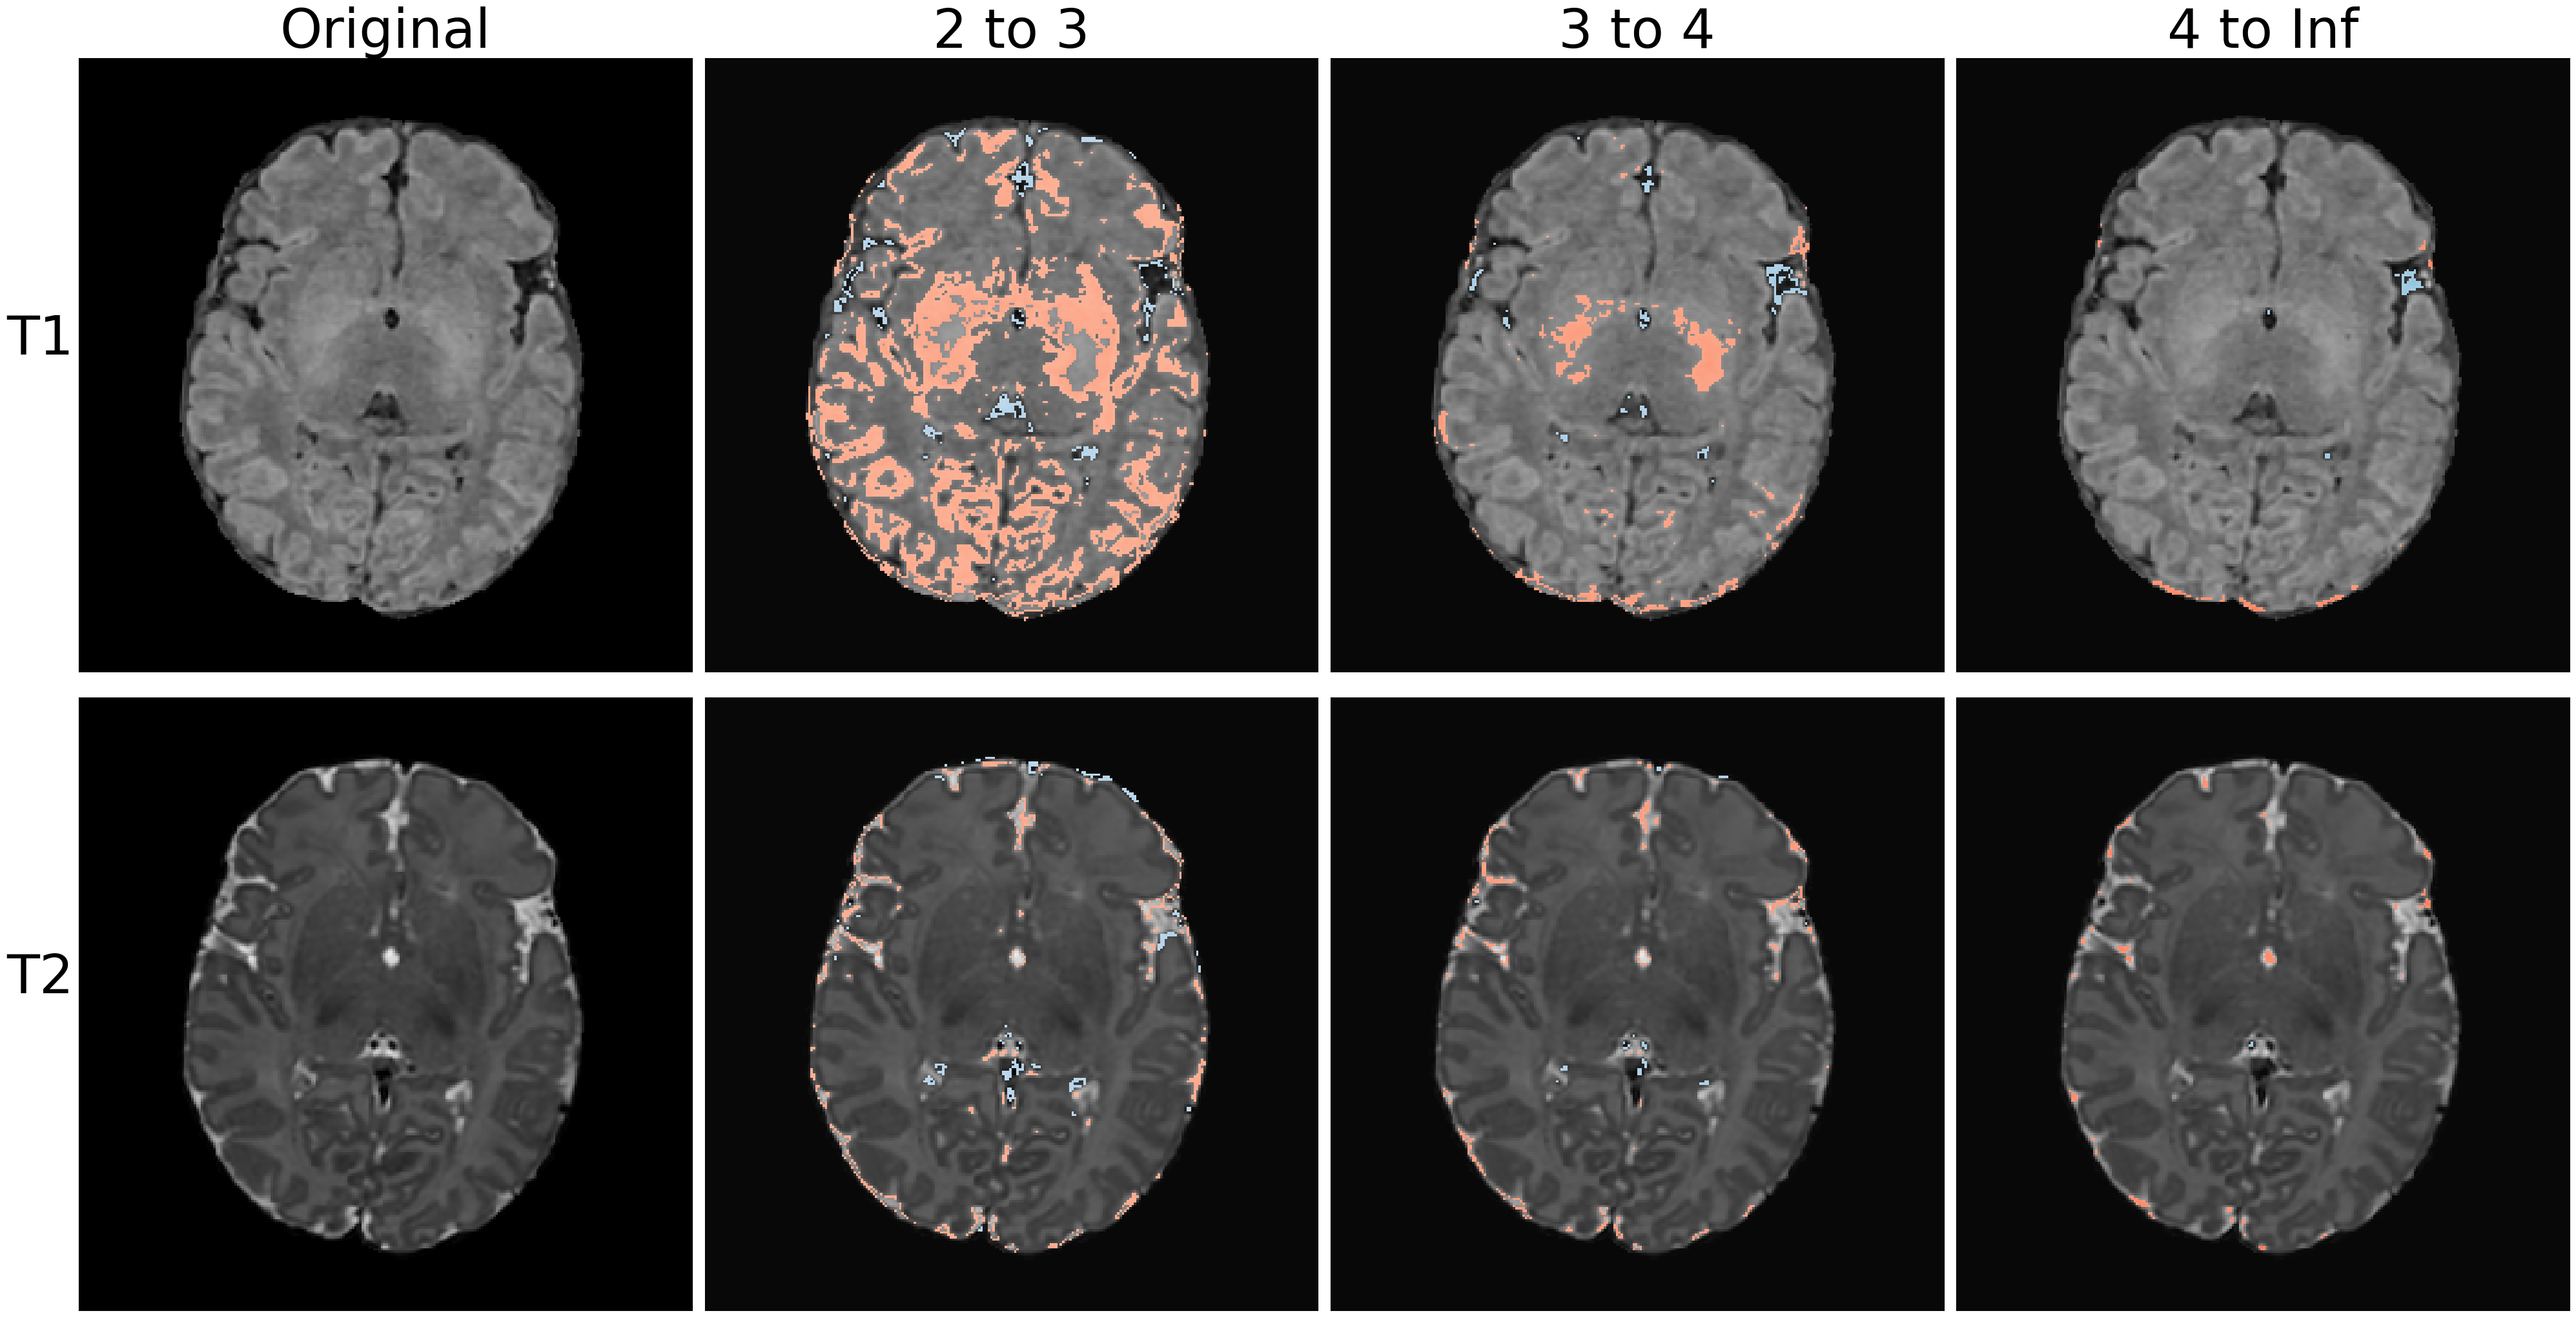

In [11]:
og_t1, norm_t1, og_t2, norm_t2 = load_image("Train", 1)
threshold = 2
filter_clusters = False

mid_idx = 128

t1_high, t1_medium, t1_low = get_banded_overlay_slice(np.sum(og_t1, axis=(0))[:,:,:],  np.sum(norm_t1, axis=(0)), mid_idx)
t2_high, t2_medium, t2_low = get_banded_overlay_slice(np.sum(og_t2, axis=(0))[:,:,:],  np.sum(norm_t2, axis=(0)), mid_idx)

fig, ax = plt.subplots(2, 4, figsize=(40, 21))

ax[0][0].imshow(np.sum(og_t1, axis=(0))[:,:,mid_idx])
ax[0][1].imshow(t1_low) 
ax[0][2].imshow(t1_medium)
ax[0][3].imshow(t1_high)

ax[1][0].imshow(np.sum(og_t2, axis=(0))[:,:,mid_idx])
ax[1][1].imshow(t2_low) 
ax[1][2].imshow(t2_medium)
ax[1][3].imshow(t2_high)

for v in ax:
    for w in v:
        # w.axis('off')
        w.set_yticks([])
        w.set_xticks([])
        
for a, col in zip(ax[0], ["Original", "2 to 3", "3 to 4", "4 to Inf"]):
    a.set_title(col, fontsize=60)

for a, row in zip(ax[:,0], ["T1", "T2"]):
    a.set_ylabel(row, rotation=0, fontsize=60, labelpad=40)

fig.tight_layout()

fig.savefig(os.path.join(fig_dir, "aio_banded_normal.png"), dpi=72)

### Normal AIO Clinical

In [14]:
t1.shape

(256, 256, 256, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


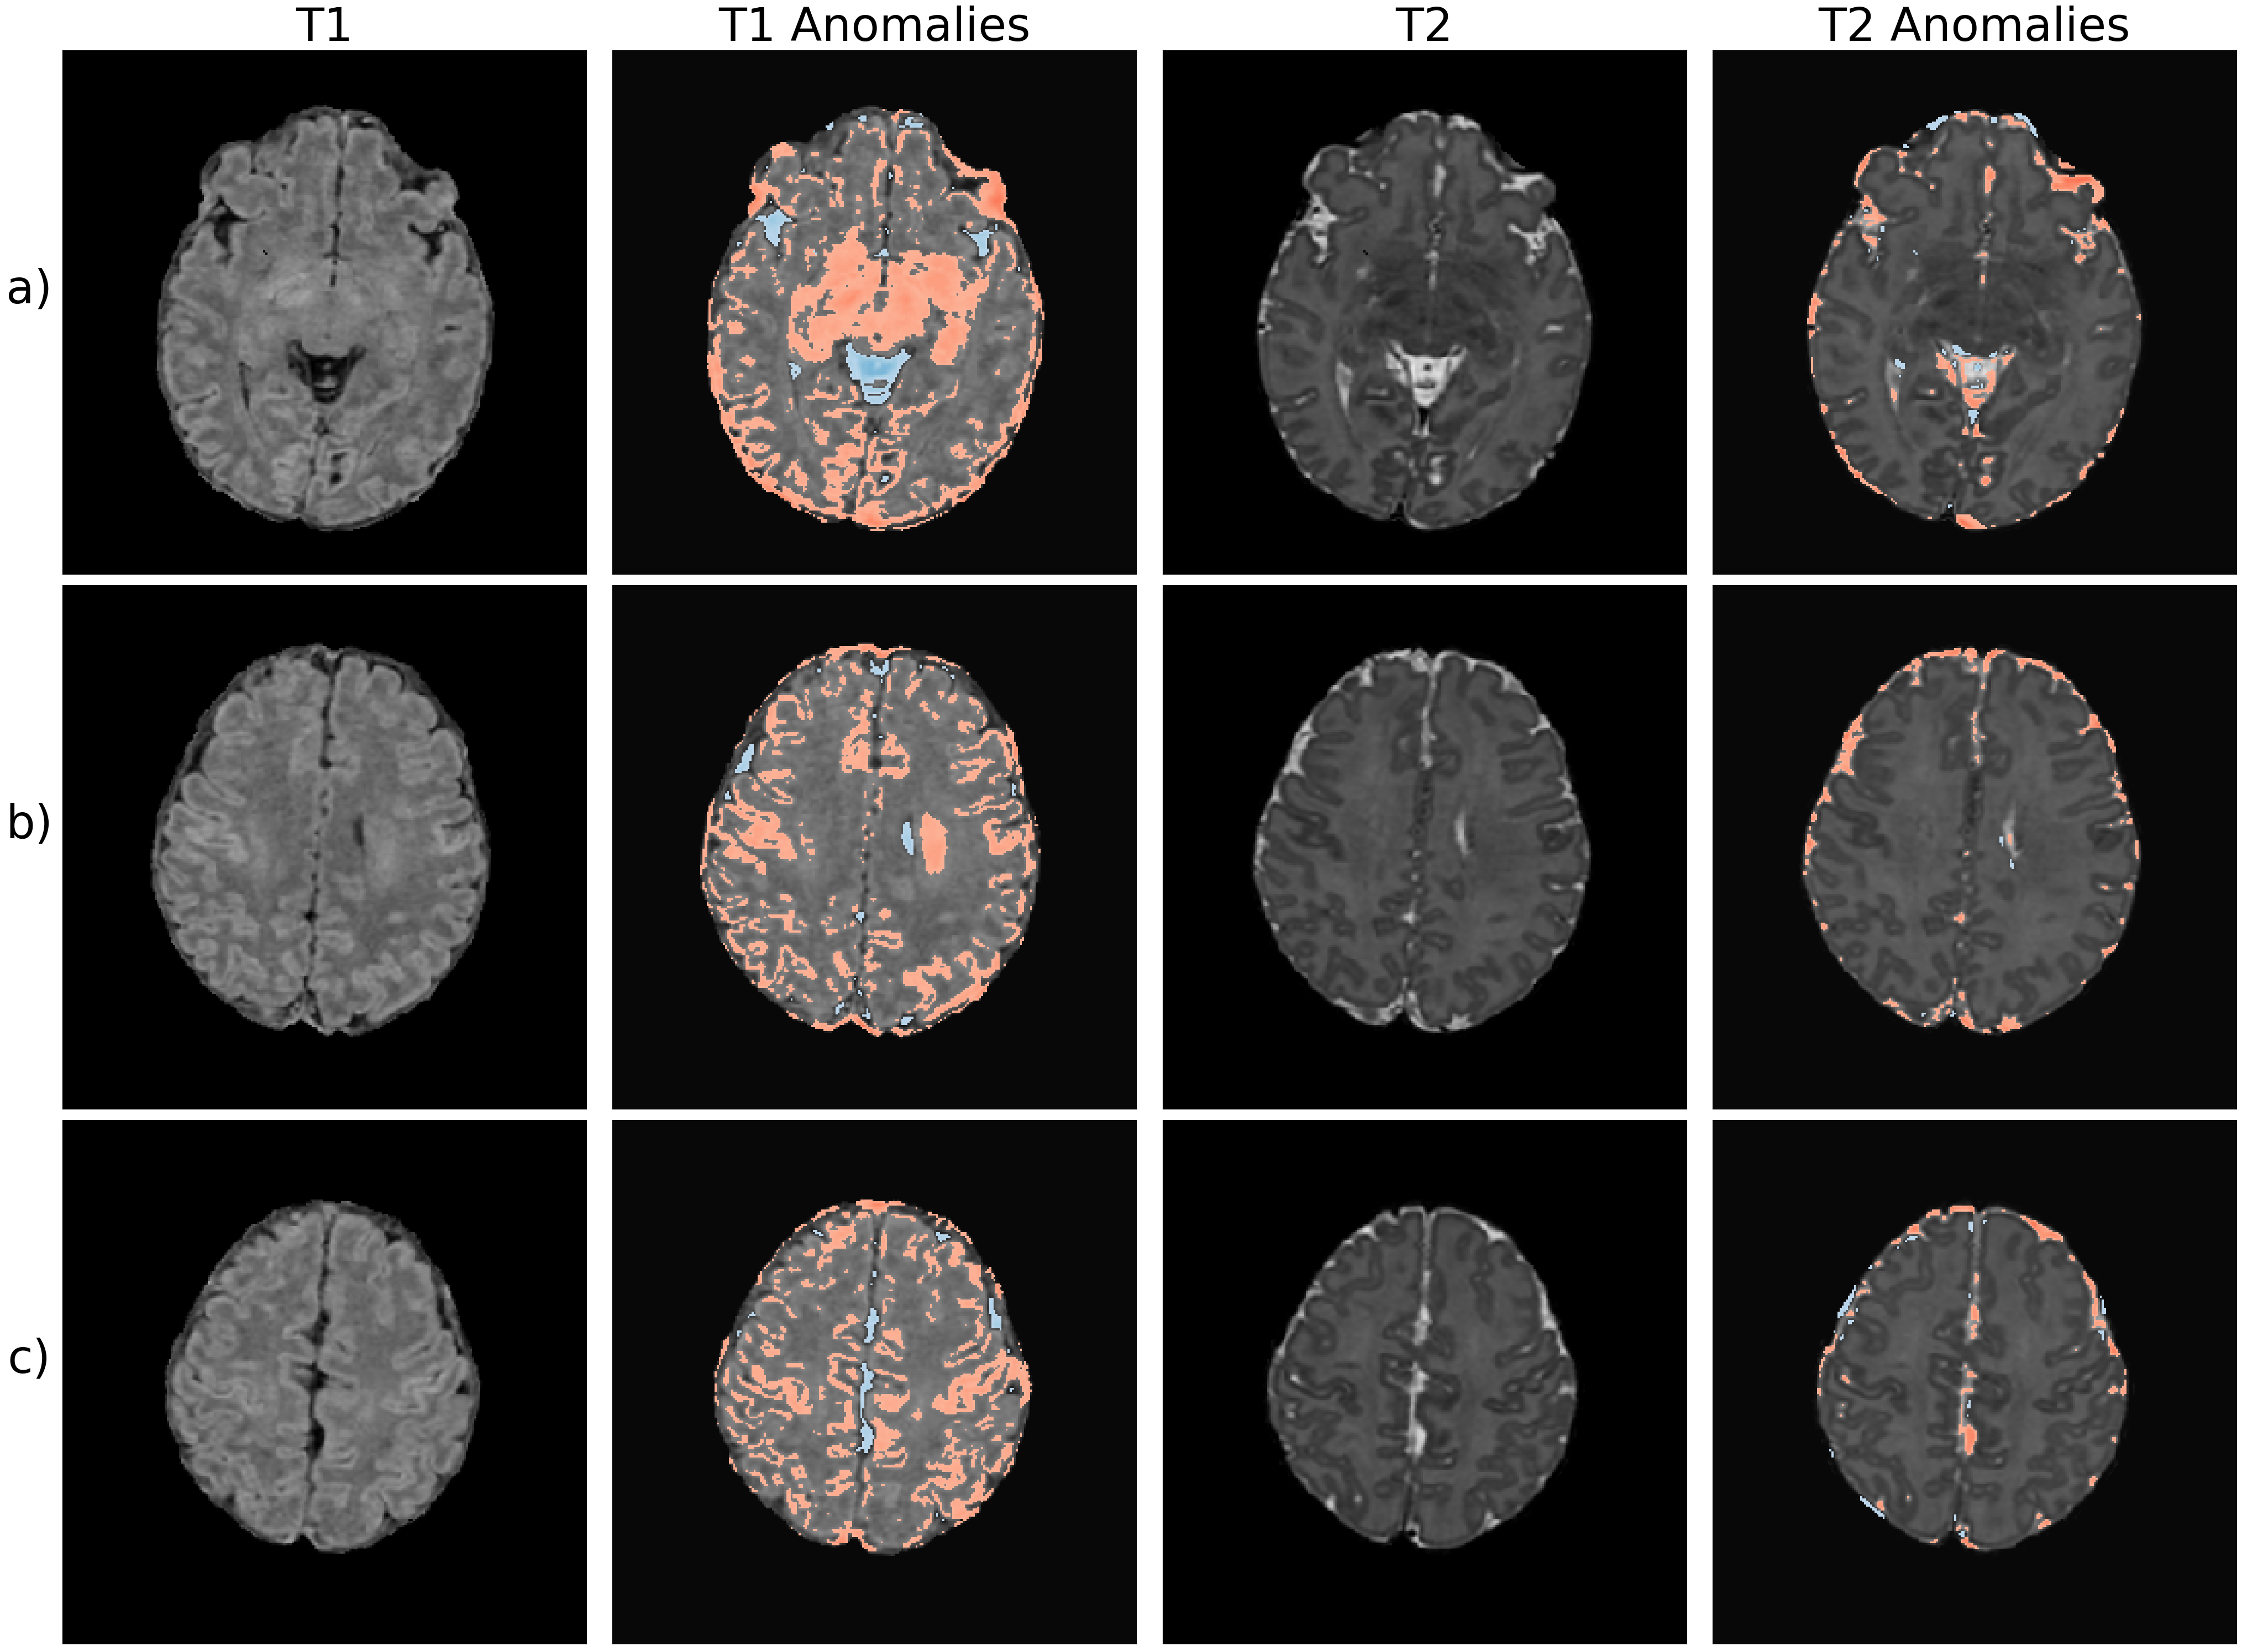

In [25]:
abi = {
    # 97:	"Overlay signal is only seen on the periphery of white matter Deep gray matter is segmented outand fair amount of cortex although difficult to access how precisely Would need to overlay on MRI images",
    105: "T2 cortical map does not work I think it is because gray matter is darker and overall the program does better with bright signal Also may be the bright CSFsignal overwhelms the thin dark cortical stripe on T1",
    176: "picked up on asymmetry in caudate and left lateral ventricle",
    196: "T2 bright sinal from underlying white matter more prominent T2 dark crtical stripe not well "
}

t1 = np.sum(og_t1, axis=(0))[:,:,:]
t1_norm = np.sum(norm_t1, axis=(0))
t2 = np.sum(og_t2, axis=(0))[:,:,:]
t2_norm = np.sum(norm_t2, axis=(0))
                 
num_slices = len(abi.keys())

fig, ax = plt.subplots(num_slices, 4, figsize=(41, num_slices * 10))

for idx, slc in enumerate(sorted(abi.keys())):
    ax[idx][0].imshow(t1[:,:,slc])
    ax[idx][1].imshow(get_slice(t1, t1_norm, slc))
    ax[idx][2].imshow(t2[:,:,slc])
    ax[idx][3].imshow(get_slice(t2, t2_norm, slc))

for v in ax:
    for w in v:
        # w.axis('off')
        # w.set_yticklabels([])
        # w.set_xticklabels([])
        w.set_yticks([])
        w.set_xticks([])

for a, col in zip(ax[0], ["T1", "T1 Anomalies", "T2", "T2 Anomalies"]):
    a.set_title(col, fontsize=60)

for a, row in zip(ax[:,0], [f"{x})" for x in "abcdefg"]):
    a.set_ylabel(row, rotation=0, fontsize=60, labelpad=40)

fig.tight_layout()

fig.savefig(os.path.join(fig_dir, "aio_normal_clinical.png"), dpi=72)




### Banded AIO Abnormal for Paper

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


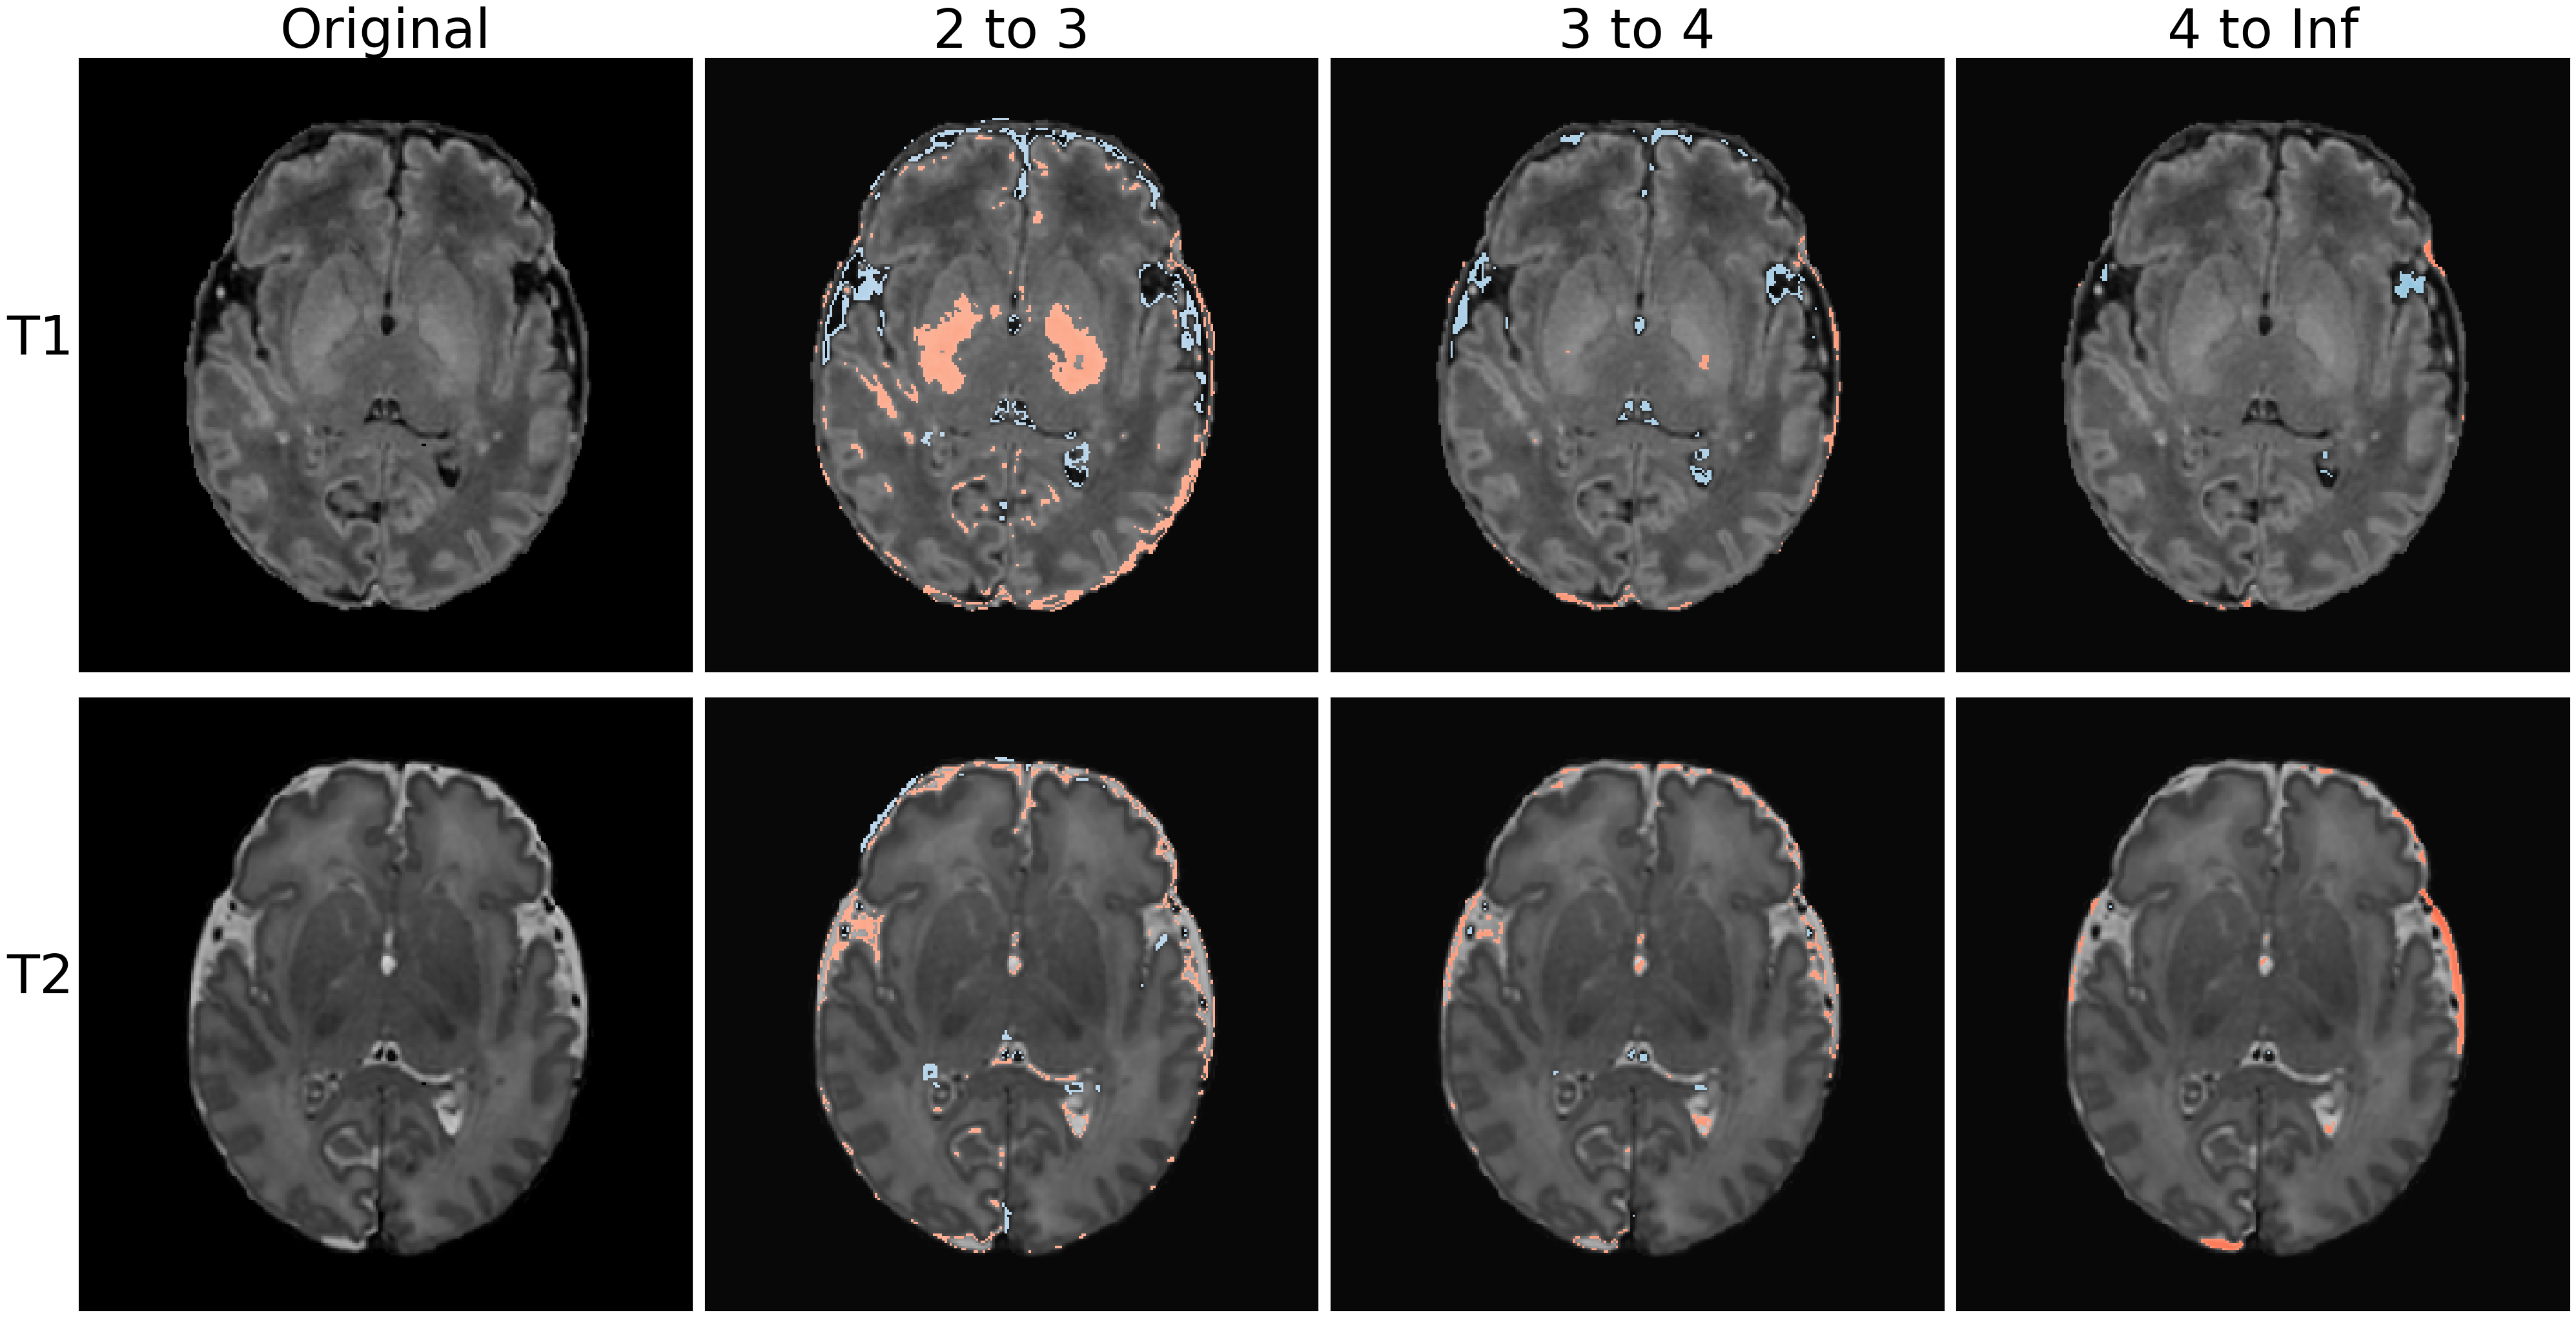

In [7]:
og_t1, norm_t1, og_t2, norm_t2 = load_image("Test", 2)
threshold = 2
filter_clusters = False

mid_idx = 128

t1_high, t1_medium, t1_low = get_banded_overlay_slice(np.sum(og_t1, axis=(0))[:,:,:],  np.sum(norm_t1, axis=(0)), mid_idx)
t2_high, t2_medium, t2_low = get_banded_overlay_slice(np.sum(og_t2, axis=(0))[:,:,:],  np.sum(norm_t2, axis=(0)), mid_idx)

fig, ax = plt.subplots(2, 4, figsize=(40, 21))

ax[0][0].imshow(np.sum(og_t1, axis=(0))[:,:,mid_idx])
ax[0][1].imshow(t1_low) 
ax[0][2].imshow(t1_medium)
ax[0][3].imshow(t1_high)

ax[1][0].imshow(np.sum(og_t2, axis=(0))[:,:,mid_idx])
ax[1][1].imshow(t2_low) 
ax[1][2].imshow(t2_medium)
ax[1][3].imshow(t2_high)

for v in ax:
    for w in v:
        # w.axis('off')
        w.set_yticks([])
        w.set_xticks([])
        
for a, col in zip(ax[0], ["Original", "2 to 3", "3 to 4", "4 to Inf"]):
    a.set_title(col, fontsize=60)

for a, row in zip(ax[:,0], ["T1", "T2"]):
    a.set_ylabel(row, rotation=0, fontsize=60, labelpad=40)

fig.tight_layout()

fig.savefig(os.path.join(fig_dir, "aio_banded_abnormal.png"), dpi=72)

In [22]:
# fig, ax = plt.subplots(1, 9, figsize=(40,20))

# for i in range(0, 9):
#     ax[i].imshow(get_slice_segment(og_t1, norm_t1, i, 128))
#     ax[i].axis("off")
#     ax[i].set_title(segments[i], fontsize=20)

# fig.tight_layout()

### For Seg 1to1

In [8]:
model_version = "1 Segment to 1 Segment"
config = model_options[model_version]
batch = "Train"
stdev_version = "Global"
subject = 1

### Banded OPS Normal

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


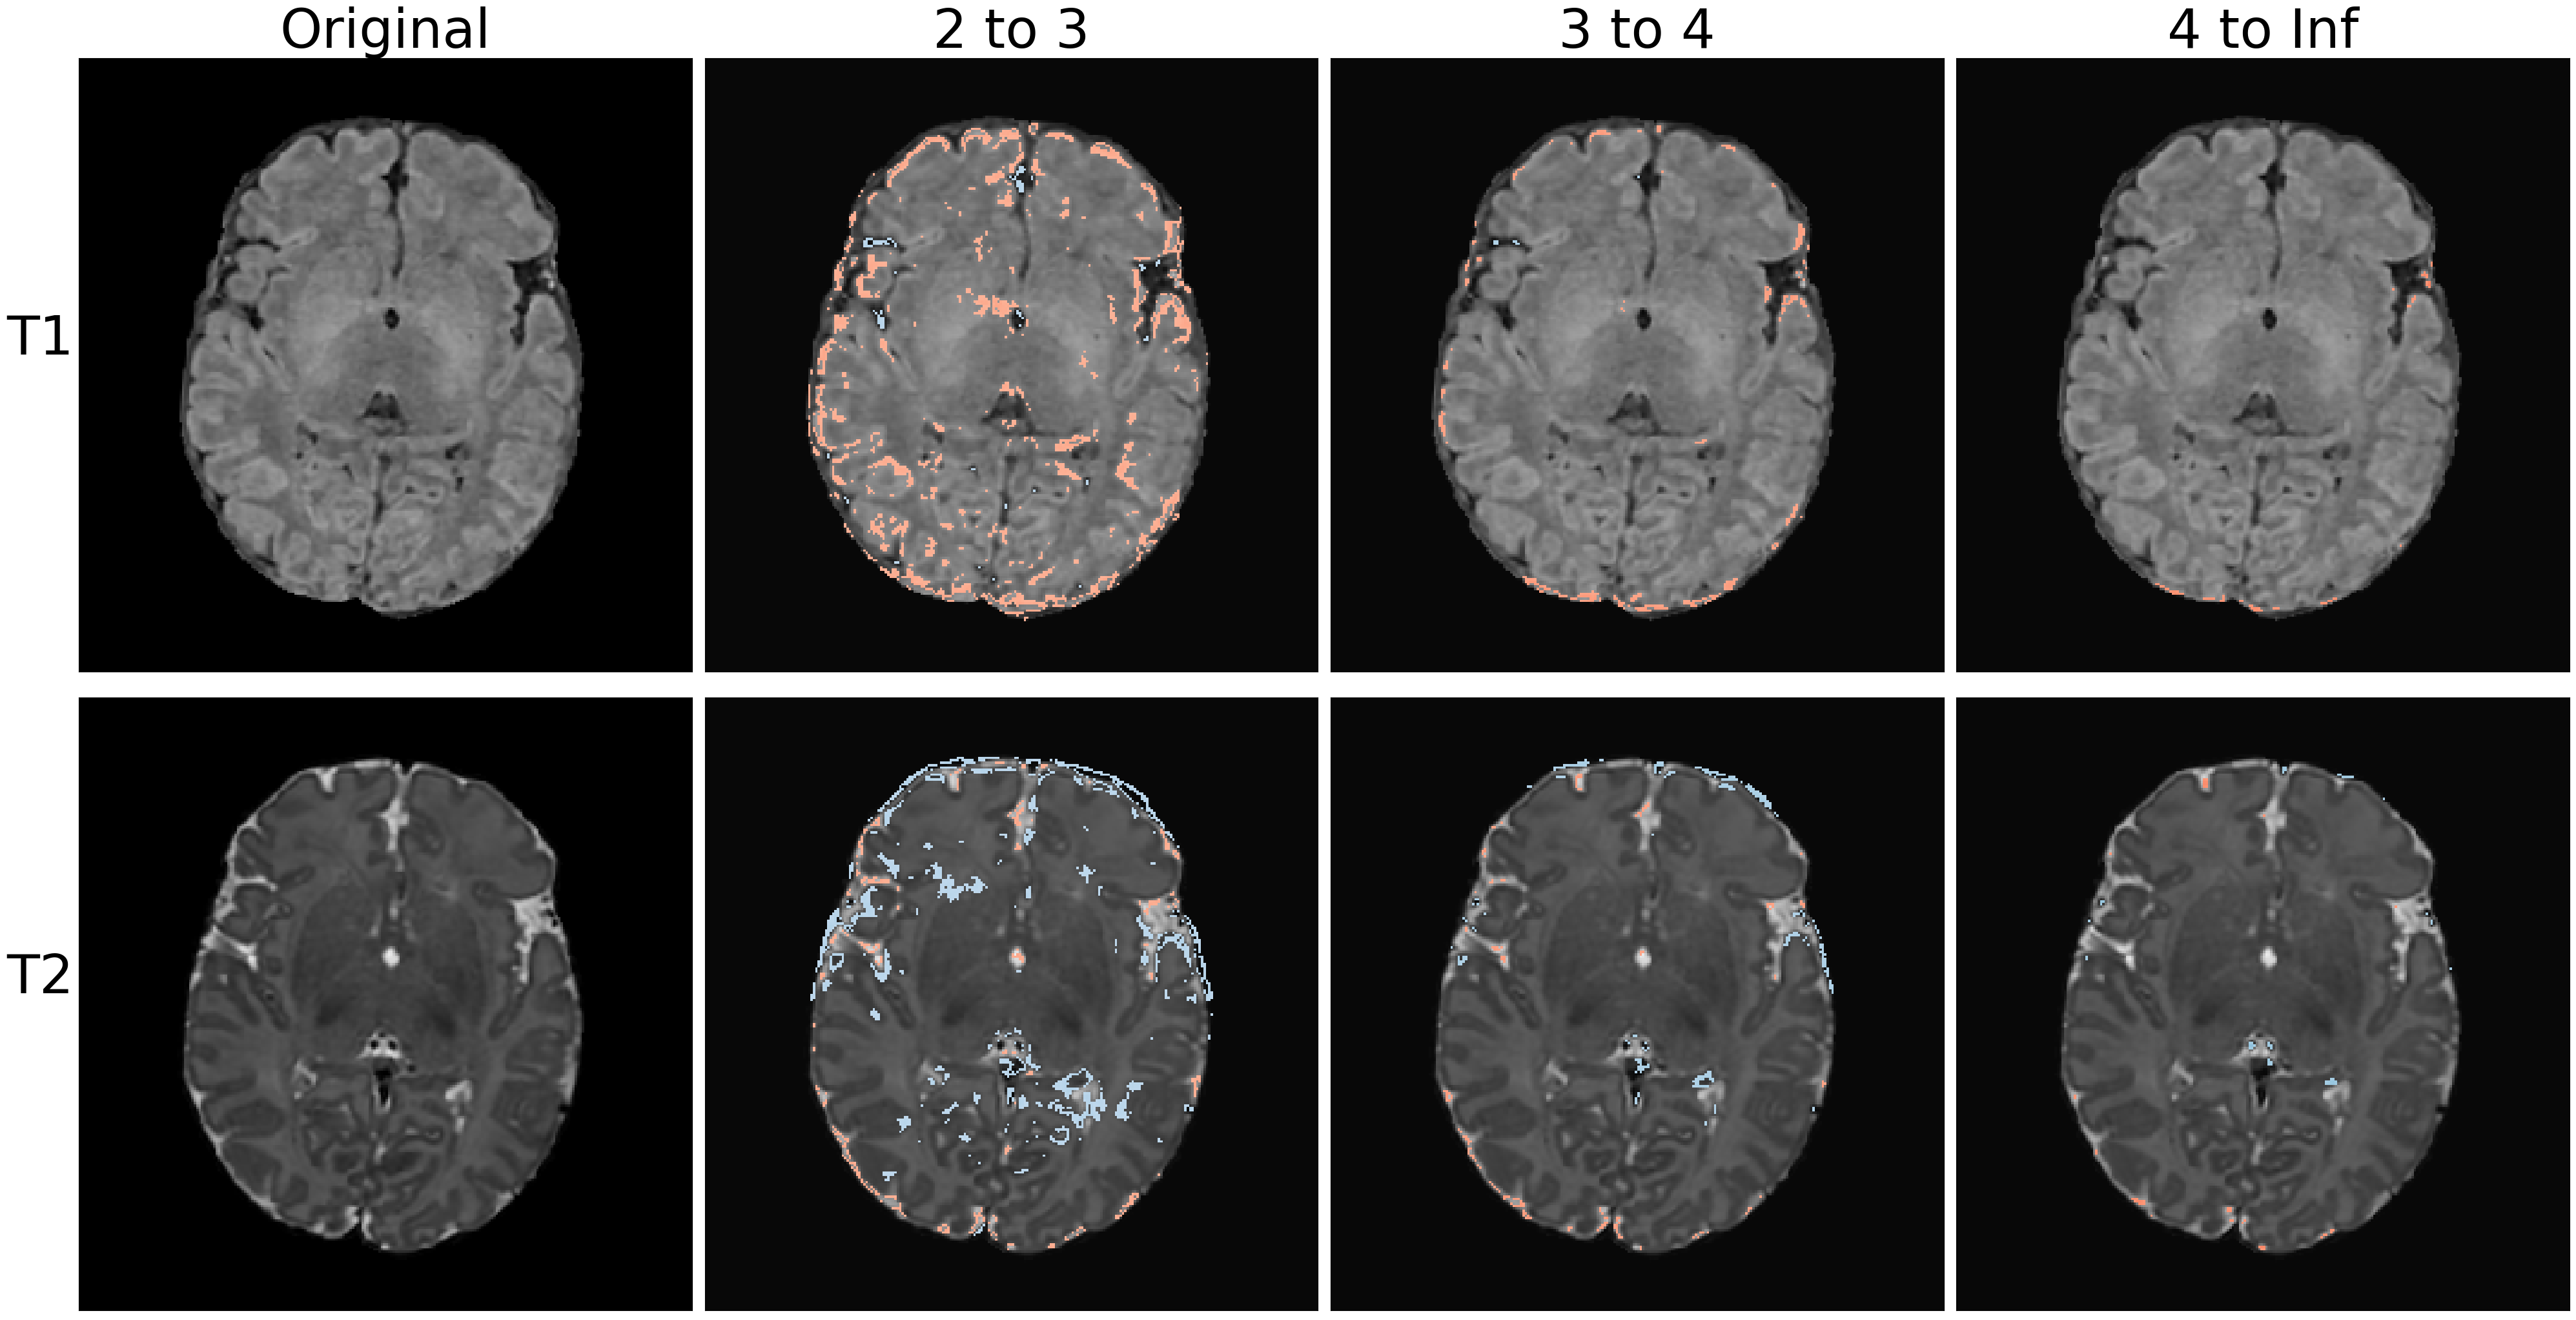

In [9]:
batch = "Train"
stdev_version = "Global"
subject = 1

og_t1, norm_t1 = load_models_data(config, batch, subject, "t1")
og_t2, norm_t2 = load_models_data(config, batch, subject, "t2")
threshold = 2
filter_clusters = False

mid_idx = 128

t1_high, t1_medium, t1_low = get_banded_overlay_slice(np.sum(og_t1, axis=(0))[:,:,:],  np.sum(norm_t1, axis=(0)), mid_idx)
t2_high, t2_medium, t2_low = get_banded_overlay_slice(np.sum(og_t2, axis=(0))[:,:,:],  np.sum(norm_t2, axis=(0)), mid_idx)

fig, ax = plt.subplots(2, 4, figsize=(40, 21))

ax[0][0].imshow(np.sum(og_t1, axis=(0))[:,:,mid_idx])
ax[0][1].imshow(t1_low) 
ax[0][2].imshow(t1_medium)
ax[0][3].imshow(t1_high)

ax[1][0].imshow(np.sum(og_t2, axis=(0))[:,:,mid_idx])
ax[1][1].imshow(t2_low) 
ax[1][2].imshow(t2_medium)
ax[1][3].imshow(t2_high)

for v in ax:
    for w in v:
        # w.axis('off')
        w.set_yticks([])
        w.set_xticks([])
        
for a, col in zip(ax[0], ["Original", "2 to 3", "3 to 4", "4 to Inf"]):
    a.set_title(col, fontsize=60)

for a, row in zip(ax[:,0], ["T1", "T2"]):
    a.set_ylabel(row, rotation=0, fontsize=60, labelpad=40)

fig.tight_layout()

fig.savefig(os.path.join(fig_dir, "ops_banded_normal.png"), dpi=72)

### Banded OPS Abnormal

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


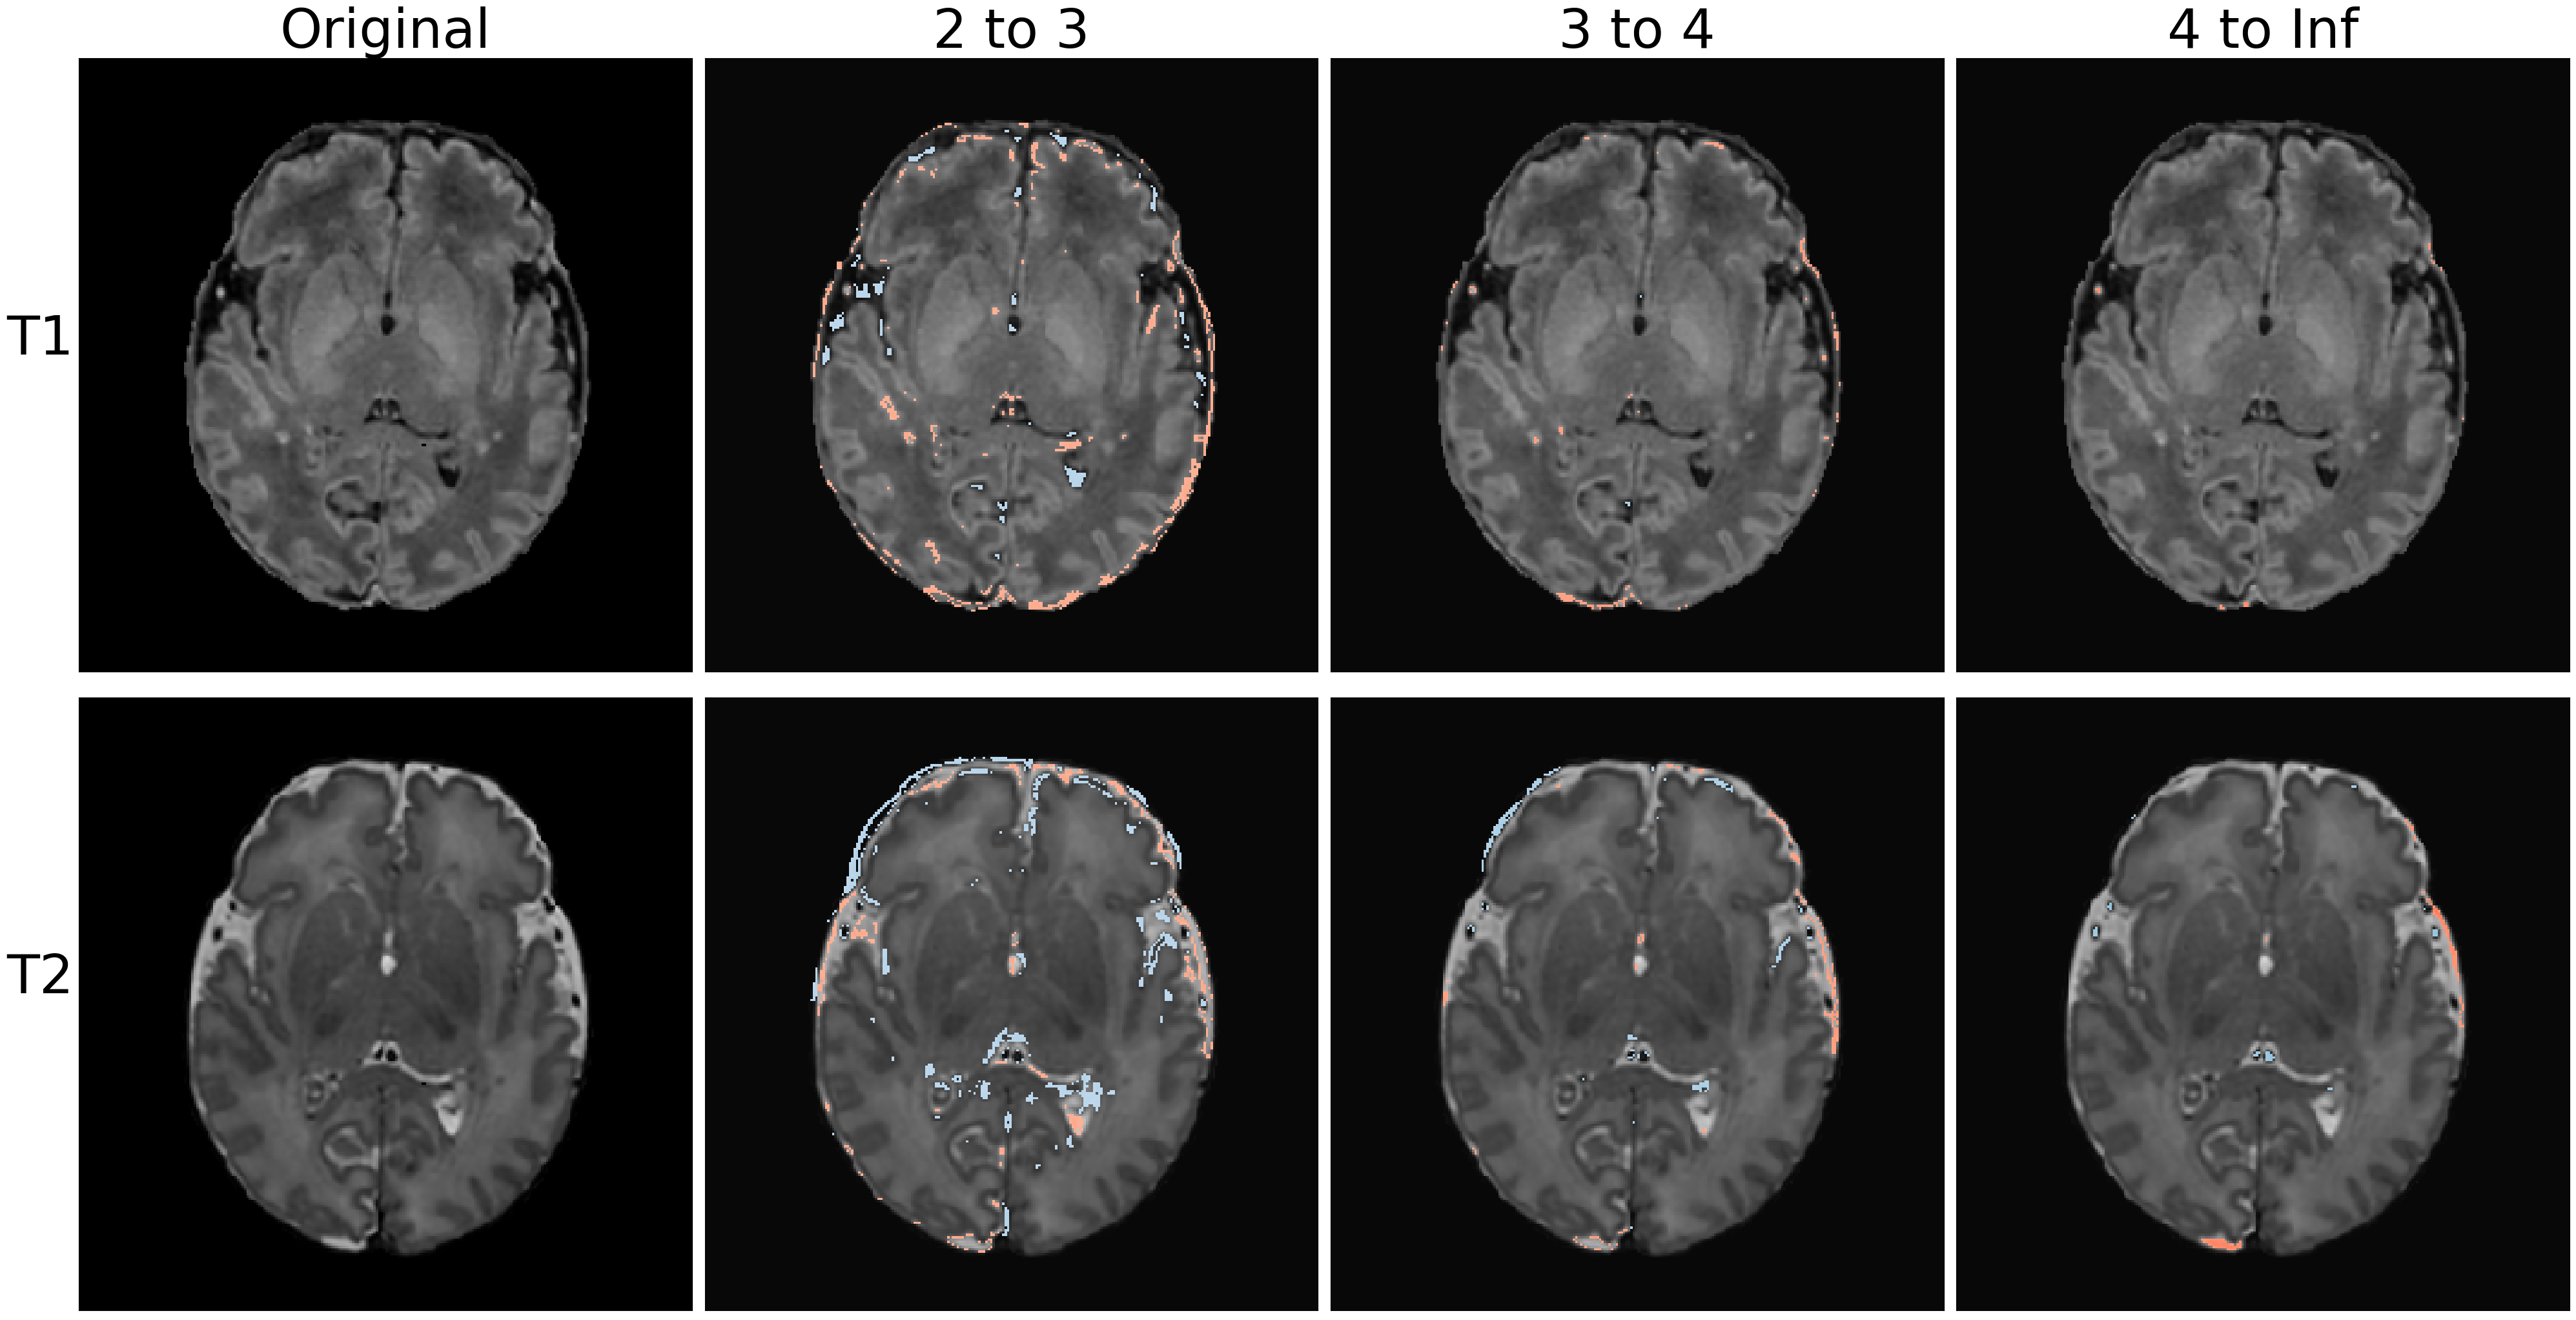

In [10]:
batch = "Test"
stdev_version = "Global"
subject = 2

og_t1, norm_t1 = load_models_data(config, batch, subject, "t1")
og_t2, norm_t2 = load_models_data(config, batch, subject, "t2")
threshold = 2
filter_clusters = False

mid_idx = 128

t1_high, t1_medium, t1_low = get_banded_overlay_slice(np.sum(og_t1, axis=(0))[:,:,:],  np.sum(norm_t1, axis=(0)), mid_idx)
t2_high, t2_medium, t2_low = get_banded_overlay_slice(np.sum(og_t2, axis=(0))[:,:,:],  np.sum(norm_t2, axis=(0)), mid_idx)

fig, ax = plt.subplots(2, 4, figsize=(40, 21))

ax[0][0].imshow(np.sum(og_t1, axis=(0))[:,:,mid_idx])
ax[0][1].imshow(t1_low) 
ax[0][2].imshow(t1_medium)
ax[0][3].imshow(t1_high)

ax[1][0].imshow(np.sum(og_t2, axis=(0))[:,:,mid_idx])
ax[1][1].imshow(t2_low) 
ax[1][2].imshow(t2_medium)
ax[1][3].imshow(t2_high)

for v in ax:
    for w in v:
        # w.axis('off')
        w.set_yticks([])
        w.set_xticks([])
        
for a, col in zip(ax[0], ["Original", "2 to 3", "3 to 4", "4 to Inf"]):
    a.set_title(col, fontsize=60)

for a, row in zip(ax[:,0], ["T1", "T2"]):
    a.set_ylabel(row, rotation=0, fontsize=60, labelpad=40)

fig.tight_layout()

fig.savefig(os.path.join(fig_dir, "ops_banded_abnormal.png"), dpi=72)